In [44]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [45]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [46]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3297355634958012277
]


In [47]:
with open('C:\\Users\\vibhu\OneDrive\\Desktop\\Handwritten-Text-Recognition-master\\parser\\words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents] 
lines[100]

'a01-000x-05-01 ok 173 679 1637 65 131 IN for'

In [48]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [49]:
images = []
labels = []

RECORDS_COUNT = 10000

In [50]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [51]:
#Deslanting the image
import cv2
import numpy as np
from collections import deque
class RotateAndDeslantImage:
    def __init__(self):
        pass
    def rotate_image(self, im):
        coords = np.column_stack(np.where(im == 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        (h, w) = im.shape[:2]
        center = (w // 2, h // 2)
        m = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(im, m, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return rotated
    def find_maxima(self, im_, row_start_idx, col_start_idx, col_stop_idx):
        li = im_[row_start_idx - 1, col_start_idx - 4:col_stop_idx + 4]
        next_li = [i for i in range(len(li)) if li[i] != 1]
        if not next_li:
            return row_start_idx, col_start_idx
        row_start_idx, col_start_idx = self.find_maxima(im_, row_start_idx - 1, col_start_idx - 2 + next_li[0],
                                           col_start_idx - 2 + next_li[-1])
        return row_start_idx, col_start_idx
    def deslant_image(self, im, pad_size=25):
        process = True
        p_img = None
        im = cv2.copyMakeBorder(im, 0, 0, pad_size, pad_size, cv2.BORDER_CONSTANT, value=1)
        # start checking for written text after skipping the padded size
        im_ = np.array(im, dtype=np.float64)
        col_start_idx = pad_size
        row_start_idx = im_[:, pad_size].tolist().index(0)
        li = im_[row_start_idx, pad_size:]
        total_cols = 0
        for i in range(len(li)):
            if li[i] != 0.0:
                total_cols = i
                break
        # calculate first maxima of black points so as to get second point of the slope line
        y2, x2 = self.find_maxima(im_, row_start_idx, col_start_idx, col_start_idx + total_cols)
        # x1, y1, are the first point of the slope line and x2, y2 are the second points
        x1, y1 = 0, im_[:, pad_size].tolist().index(0)
        c = im_[:, pad_size].tolist().index(0)
        m = 0
        if y2 - y1 != 0:
            m = (x2 - x1) / (y2 - y1)
        else:
            process = False
            p_img = im_
        y = []
        # if a slope is detected then shift the pixels in the image to make it straight otherwise pass this step
        if process:
            for i in range(im_.shape[0]):
                y.append((((i * m) + c), i))
            processed = []
            for i in zip(im_, y):
                li = deque(i[0])
                count = int(i[1][0])
                if count > 0:
                    while count != 0:
                        li.popleft()
                        count -= 1
                    li = np.array(li)
                    li = np.lib.pad(li, (0, i[0].shape[0] - len(li)), 'maximum', )
                else:
                    count = abs(count)
                    while count != 0:
                        li.pop()
                        count -= 1
                    li = np.array(li)
                    li = np.lib.pad(li, (i[0].shape[0] - len(li), 0), 'maximum', )
                processed.append(li)
            p_img = np.array(processed)
        return p_img
    
def process_image(img):
    #DESLANT THE IMAGE (SKEW CORRECTION)
    #p = RotateAndDeslantImage()
    #img = p.deslant_image(img)
    
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    return img

In [52]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\words\\{}\\{}-{}\\{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [53]:

train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [54]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [55]:

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [56]:
train_images.shape

(7850, 32, 128, 1)

In [57]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
pool_3 = MaxPool2D(pool_size=(2, 1))(conv_3)
conv_4 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_3)
batch_norm_4 = BatchNormalization()(conv_4)
pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm_4)
conv_5 = Conv2D(512, (2,2), activation = 'relu')(pool_4)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_5)
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
# model to be used at test time
act_model = Model(inputs, outputs)

In [58]:
act_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 32, 256)        0         
__________

In [59]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [60]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [61]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [62]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Train on 7850 samples, validate on 876 samples
Epoch 1/30
 - 692s - loss: 15.9421 - acc: 0.0000e+00 - val_loss: 14.8750 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 14.87498, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 2/30
 - 637s - loss: 13.7175 - acc: 0.0015 - val_loss: 13.3337 - val_acc: 0.0365

Epoch 00002: val_loss improved from 14.87498 to 13.33373, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 3/30
 - 628s - loss: 12.0081 - acc: 0.0406 - val_loss: 14.2314 - val_acc: 0.0559

Epoch 00003: val_loss did not improve from 13.33373
Epoch 4/30
 - 625s - loss: 10.3420 - acc: 0.0670 - val_loss: 10.1171 - val_acc: 0.1130

Epoch 00004: val_loss improved from 13.33373 to 10.11711, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 5/30
 - 629s - loss: 8.5963 - acc: 0.1036 - val_loss: 9.8496 - val_acc: 0.1301

Epoch 00005: val_loss improved from 10.11711 to 9.84956, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 6/30
 - 728s - loss: 6.7245 - a

In [63]:
# load the saved best model weights
filepath = "sgdo-10000r-30e-7850t-876v.hdf5"
act_model.load_weights(filepath)

original_text =   large
predicted text = large

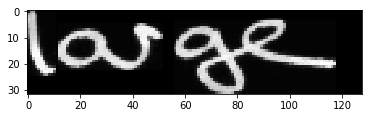



original_text =   majority
predicted text = majority

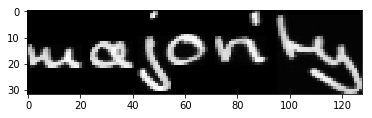



original_text =   of
predicted text = af

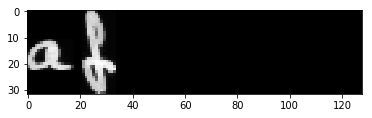



original_text =   Labour
predicted text = Labour

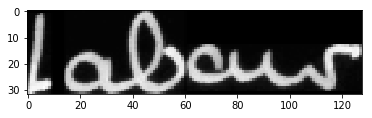



original_text =   MPs
predicted text = MPs

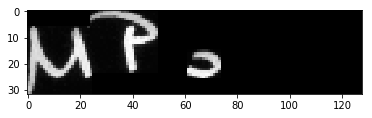



original_text =   are
predicted text = are

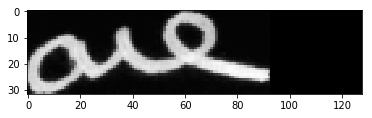



original_text =   to
predicted text = to

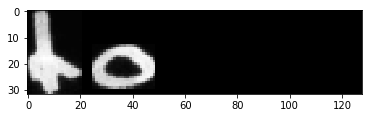



original_text =   turn
predicted text = trn

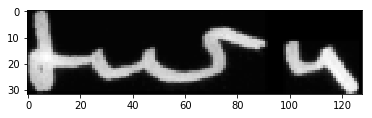



original_text =   down
predicted text = down

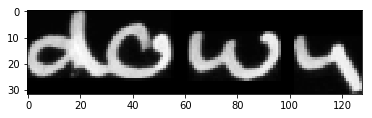



original_text =   the
predicted text = the

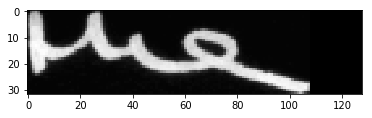



original_text =   Foot-
predicted text = Foot-

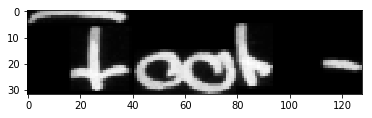



original_text =   be
predicted text = be

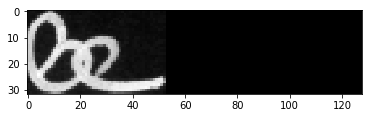



original_text =   that
predicted text = that

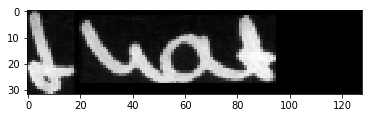



original_text =   as
predicted text = as

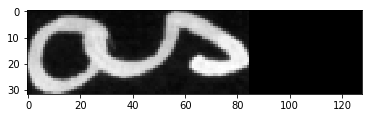



original_text =   Labour
predicted text = Labouur

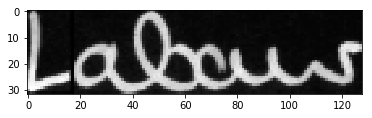



original_text =   MPs
predicted text = MPs

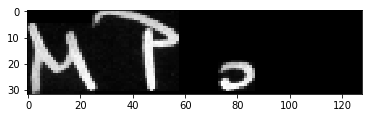



original_text =   opposed
predicted text = opposed

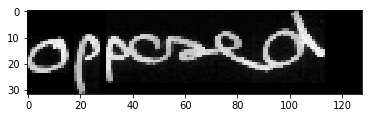



original_text =   the
predicted text = the

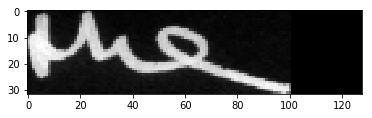



original_text =   Bill
predicted text = Bill

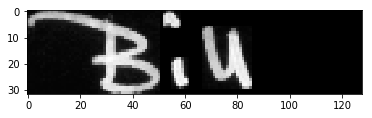



original_text =   which
predicted text = which

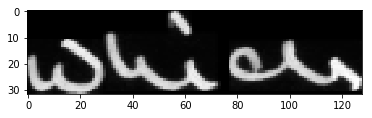

In [64]:
prediction = act_model.predict(train_images[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)
# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[150+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [65]:
import os
import math
import cv2
import numpy as np


def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
	"""Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf
	
	Args:
		img: grayscale uint8 image of the text-line to be segmented.
		kernelSize: size of filter kernel, must be an odd integer.
		sigma: standard deviation of Gaussian function used for filter kernel.
		theta: approximated width/height ratio of words, filter function is distorted by this factor.
		minArea: ignore word candidates smaller than specified area.
		
	Returns:
		List of tuples. Each tuple contains the bounding box and the image of the segmented word.
	"""

	# apply filter kernel
	kernel = createKernel(kernelSize, sigma, theta)
	imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
	(_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	imgThres = 255 - imgThres

	# find connected components. OpenCV: return type differs between OpenCV2 and 3
	if cv2.__version__.startswith('3.'):
		(_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	else:
		(components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

	# append components to result
	res = []
	for c in components:
		# skip small word candidates
		if cv2.contourArea(c) < minArea:
			continue
		# append bounding box and image of word to result list
		currBox = cv2.boundingRect(c) # returns (x, y, w, h)
		(x, y, w, h) = currBox
		currImg = img[y:y+h, x:x+w]
		res.append((currBox, currImg))

	# return list of words, sorted by x-coordinate
	return sorted(res, key=lambda entry:entry[0][0])


def prepareImg(img, height):
	"""convert given image to grayscale image (if needed) and resize to desired height"""
	assert img.ndim in (2, 3)
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	h = img.shape[0]
	factor = height / h
	return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def createKernel(kernelSize, sigma, theta):
	"""create anisotropic filter kernel according to given parameters"""
	assert kernelSize % 2 # must be odd size
	halfSize = kernelSize // 2
	
	kernel = np.zeros([kernelSize, kernelSize])
	sigmaX = sigma
	sigmaY = sigma * theta
	
	for i in range(kernelSize):
		for j in range(kernelSize):
			x = i - halfSize
			y = j - halfSize
			
			expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
			xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
			yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)
			
			kernel[i, j] = (xTerm + yTerm) * expTerm

	kernel = kernel / np.sum(kernel)
	return kernel


In [66]:
def main():
	"""reads images from data/ and outputs the word-segmentation to out/"""

	# read input images from 'in' directory
	#imgFiles = os.listdir('C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u')
	#for (i,f) in enumerate(imgFiles):
		#print('Segmenting words of sample %s'%f)
		
		# read image, prepare it by resizing it to fixed height and converting it to grayscale
	img = prepareImg(cv2.imread('C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u\\a01-000u-00.png'), 50)
		
		# execute segmentation with given parameters
		# -kernelSize: size of filter kernel (odd integer)
		# -sigma: standard deviation of Gaussian function used for filter kernel
		# -theta: approximated width/height ratio of words, filter function is distorted by this factor
		# - minArea: ignore word candidates smaller than specified area
	res = wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=100)
		
		# write output to 'out/inputFileName' directory
		#if not os.path.exists('C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u\\out\\'+f):
			#os.mkdir('C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u\\out\\' + f)
		
		# iterate over all segmented words
	print('Segmented into %d words'%len(res))
	for (j, w) in enumerate(res):
		(wordBox, wordImg) = w
		(x, y, w, h) = wordBox
		cv2.imwrite('C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u\\%d.png'%(j), wordImg) # save word
		cv2.rectangle(img,(x,y),(x+w,y+h),0,1) # draw bounding box in summary image
		
		# output summary image with bounding boxes around words
		#cv2.imwrite('../out/%s/summary.png'%f, img)


if __name__ == '__main__':
	main()

Segmented into 7 words


In [121]:
filepath="sgdo-10000r-30e-7850t-876v.hdf5"

In [122]:
act_model.load_weights(filepath)

Original Sentence = A move to stop Mr. Gaitskell from
Predicted Sentence =  . M0E s 3r r Gaitskell fromn


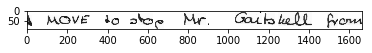

In [123]:
import glob
testpredict = []
for filename in glob.glob("C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u\\out/*.png"):
    img = cv2.imread(filename)
    a = img.shape[0]
    b = img.shape[1]*img.shape[2]
    img.resize(a,b)
    img = process_image(img)
    testpredict.append(img)
    #print(img.shape)
testpredict = np.asarray(testpredict)
prediction = act_model.predict(testpredict)
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)
# see the results
l2 = []
for i, x in enumerate(out):
    l1 = []
    for p in x:
        if int(p) != -1:
            l1.append(char_list[int(p)])
    l2.append(''.join(l1))   
im = cv2.imread("C:\\Users\\vibhu\\OneDrive\\Desktop\\TCS ion\\data\\lines\\a01\\a01-000u\\a01-000u-00.png")
plt.imshow(im)
print("Original Sentence = A move to stop Mr. Gaitskell from")
print("Predicted Sentence =  "+' '.join(l2))
